<a href="https://colab.research.google.com/github/rahultrada/Sarcasm_Detection/blob/master/Sarcasm_Detection_RNN%2CLSTM%2CGRU%2CCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**References**

https://github.com/bentrevett/pytorch-sentiment-analysis

https://www.kaggle.com/viveksasikumar/blending-bidir-gru-cnn-gensim-with-svc-95



In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.metrics import accuracy_score,log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

import time

Using TensorFlow backend.


In [ ]:
!pip install scikit-plot
import scikitplot.metrics as skplt

In [ ]:
data = pd.read_json('https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json', lines = True)
data = data[["headline", "is_sarcastic"]]
data.head()

NameError: ignored

0    14985
1    13634
Name: is_sarcastic, dtype: int64


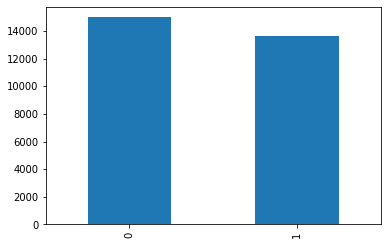

In [ ]:
print(data["is_sarcastic"].value_counts())
data["is_sarcastic"].value_counts().plot.bar()
plt.show()

##**Load pretrained Word2Vec word embeddings**

In [ ]:
EMBEDDING_DIM = 300

In [ ]:
import gensim
embeddings = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)  

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##**Data Split (Train/Validation/Test)**


In [ ]:
train_df, test_df = train_test_split(data, test_size=0.15, random_state=101)
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=101)
print("Train size:{}".format(train_df.shape))
print("Validation size:{}".format(val_df.shape))
print("Test size:{}".format(test_df.shape))


Train size:(19460, 2)
Validation size:(4866, 2)
Test size:(4293, 2)


In [ ]:
## Get the news headlines
train_X = train_df["headline"].values
val_X = val_df["headline"].values
test_X = test_df["headline"].values

## Get the target values
train_y = train_df['is_sarcastic'].values
val_y = val_df['is_sarcastic'].values
test_y = test_df['is_sarcastic'].values

##**Data Proprocessing (Tokenization and Padding)**

In [ ]:
max_features = 50000
maxlen = 152

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features,oov_token=1)
tokenizer.fit_on_texts(train_X)
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

In [ ]:
word_index = tokenizer.word_index
print(len(word_index))

25497


In [ ]:
## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

##**Create pretrained embedding matrix**

In [ ]:
#If word not in pretrained embeddings, assign it to the UNK embedding vector
def embedding(token):
  if token not in embeddings:
    return embeddings['UNK'] #np.random.normal(scale=0.6, size=(EMBEDDING_DIM, )) #embeddings['UNK'] #randomly initialise
  return embeddings[token]

In [ ]:
#Create the pretrained embedding matrix
def create_embedding_matrix(): 
  embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
    #Since indexed at 1, the first row of the embedding matrix is the padding (0)
    embedding_matrix[i] = embedding(word)
  return torch.tensor(embedding_matrix, dtype=torch.float32)

##**Transfrom from numpy to tensor objects**

In [ ]:
#Create tensor objects
train_X_tensor = torch.tensor(train_X, dtype=torch.long)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)

val_X_tensor = torch.tensor(val_X, dtype=torch.long)
val_y_tensor = torch.tensor(val_y, dtype=torch.float32)

test_X_tensor = torch.tensor(test_X, dtype=torch.long)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

In [ ]:
train_labels = train_y_tensor.cpu()
valid_labels = val_y_tensor.cpu()
test_labels = test_y_tensor.cpu()     

##**Create tensor datasets and data loaders**

In [ ]:
#Create tensor datasets and dataloaders
batch_size = 1024

train_set = TensorDataset(train_X_tensor, train_y_tensor)
valid_set = TensorDataset(val_X_tensor, val_y_tensor)
test_set = TensorDataset(test_X_tensor, test_y_tensor)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


##**Define accuracy function**

In [ ]:
  def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

##**Define train function**

In [ ]:
def train(model, data_loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(inputs).squeeze(1)
        
        loss = criterion(output, labels)
        
        acc = binary_accuracy(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

##**Define evaluation function**

In [ ]:
def evaluate(model, data_loader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in data_loader:
          inputs, labels = inputs.to(device), labels.to(device)
    
          output = model(inputs).squeeze(1)
          
          loss = criterion(output, labels)
          
          acc = binary_accuracy(output, labels)

          epoch_loss += loss.item()
          epoch_acc += acc.item()
        
    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
 import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

##**Define visualization function**

In [ ]:
def visualize_training(trained_model):
  fig = plt.figure(figsize=plt.figaspect(0.2))
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(trained_model.epoch_train_losses,label = "Training Loss")
  ax1.plot(trained_model.epoch_valid_losses,label = "Validation Loss")
  plt.legend()
  plt.xlabel('Epoch')

  ax1 = fig.add_subplot(1, 2, 2)
  ax1.plot(trained_model.epoch_train_accs,label = "Training Accuracy")
  ax1.plot(trained_model.epoch_valid_accs,label = "Validation Accuracy")
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


##**Define training loop**

In [ ]:
class TrainedModel:
  def __init__(self, model):

    self.name = model.model_name()
    self.variant = model.variant

    self.epoch_train_losses = []
    self.epoch_valid_losses = []

    self.epoch_train_accs = []
    self.epoch_valid_accs = []

    self.best_val_loss = float('inf')
    self.best_val_accuracy = 0.0
    self.best_val_f1_score = 0.0
    self.best_val_matthews_corrcoef = 0.0
    self.best_epoch = 0

  def epoch_run(self,train_loss, train_acc, valid_loss, valid_acc):
    self.epoch_train_losses.append(train_loss)
    self.epoch_train_accs.append(train_acc)
    self.epoch_valid_losses.append(valid_loss)
    self.epoch_valid_accs.append(valid_acc)
  
  def record_best_valid_metrics(self, loss, accuracy, f1_score = None, matthews_corrcoeff = None ):
    self.best_val_loss = loss
    self.best_val_accuracy = accuracy
    if f1_score is not None:
      self.best_val_f1_score = f1_score
    if matthews_corrcoeff is not None:
      self.best_val_matthews_corrcoef = matthews_corrcoeff

  def record_best_epoch(self, best_epoch):
    self.best_epoch = best_epoch


In [ ]:
def fit(model, n_epochs = 100, patience = 15, lr = 1e-3, verbose= False):

  best_valid_loss = float('inf')
  best_epoch = 0
  model.to(device)
  trained_model = TrainedModel(model)

  for epoch in range(1,n_epochs):

      optimizer = optim.Adam(model.parameters(), lr=lr)
      criterion = nn.BCEWithLogitsLoss()
      criterion = criterion.to(device)

      start_time = time.time()
      
      train_loss, train_acc = train(model, train_loader, optimizer, criterion)
      valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
      
      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      trained_model.epoch_run(train_loss, train_acc, valid_loss, valid_acc)

      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          best_epoch = epoch
          trained_model.record_best_valid_metrics(best_valid_loss, valid_acc)
          trained_model.record_best_epoch(best_epoch)
          torch.save(model.state_dict(), f'./{model.model_name()}.pt')
      
      if verbose:
        print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

      if (epoch-best_epoch) > patience:
        print(f'Early stopping at epoch {epoch}')
        break
    
  visualize_training(trained_model)

  return trained_model

##**Build model architectures**


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = False, freeze = True, drate =0.5):
        super().__init__()

        self.variant = self.get_variant_name()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.linear_layers = linear_layers
        self.pretrained = pretrained
        self.freeze = freeze
        self.drate = drate

        if pretrained:
          self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze)
        else:
          self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.rnn = self.define_rnn_variant()
            
        layerlist = []
        n_in = hidden_dim *2 if self.bidirectional else hidden_dim
        
        #1 Linear Layer
        if len(linear_layers) ==0:
          n_in = hidden_dim *2 if self.bidirectional else hidden_dim
          layerlist.append(nn.Linear(n_in,output_dim))   
        else:
        #MLP
          for i in linear_layers:
              layerlist.append(nn.Linear(n_in,i)) 
              layerlist.append(nn.ReLU(inplace=True))
              layerlist.append(nn.BatchNorm1d(i))
              layerlist.append(nn.Dropout(drate))
              n_in = i
          layerlist.append(nn.Linear(linear_layers[-1],output_dim))
    
        self.layers = nn.Sequential(*layerlist)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, ht = self.rnn(embedded)
        if self.bidirectional:
          x = torch.cat((ht[-2,:,:], ht[-1,:,:]), dim = 1)
        else:
          x = ht[-1,:,:]
        x = self.layers(x)
        return x
    
    def get_variant_name(self):
      return 'RNN' 
    
    def define_rnn_variant(self):
      return nn.RNN(self.embedding_dim, self.hidden_dim, num_layers=self.num_layers, bidirectional=self.bidirectional, dropout = self.drate, batch_first = True)

    def model_name(self):
      return f'{self.variant}_PRE({self.pretrained})_HD({self.hidden_dim})_NL({self.num_layers})_B({self.bidirectional})_LL({self.linear_layers})_FR({self.freeze})_DR({self.drate})'

In [ ]:
class LSTM(RNN):
    def __init__(self, input_dim, embedding_dim, embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = False, freeze = True, drate =0.5):
        super().__init__(input_dim, embedding_dim, embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained, freeze, drate)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, (ht,ct) = self.rnn(embedded)
        if self.bidirectional:
          x = torch.cat((ht[-2,:,:], ht[-1,:,:]), dim = 1)
        else:
          x = ht[-1,:,:]
        x = self.layers(x)
        return x
    
    def get_variant_name(self):
      return 'LSTM' 
    
    def define_rnn_variant(self):
      return nn.LSTM(self.embedding_dim, self.hidden_dim, num_layers=self.num_layers, bidirectional=self.bidirectional, dropout = self.drate, batch_first = True)
    

In [ ]:
class GRU(RNN):
    def __init__(self, input_dim, embedding_dim, embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = False, freeze = True, drate =0.5):
        super().__init__(input_dim, embedding_dim, embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained, freeze, drate)

    def get_variant_name(self):
      return 'GRU' 

    def define_rnn_variant(self):
      return nn.GRU(self.embedding_dim, self.hidden_dim, num_layers=self.num_layers, bidirectional=self.bidirectional, dropout = self.drate, batch_first = True)

In [ ]:
#create CNN here
class CNN1d(nn.Module):
    def __init__(self, input_dim, embedding_dim, embedding_matrix, n_filters, filter_sizes, output_dim, 
                 linear_layers, pretrained = False, freeze = True, lr=1e-4,drate =0.5):
        super().__init__()

        self.variant = 'CNN1d'
        self.pretrained = pretrained
        self.freeze = freeze
        self.drate = drate
        self.lr = lr
        self.n_filters = n_filters
        self.filter_sizes = filter_sizes
        self.dropout = nn.Dropout(drate)
        self.linear_layers = linear_layers
        
        if pretrained:
          self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze)
        else:
          self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])
        layerlist = []
        n_in = len(filter_sizes) * n_filters
        for i in linear_layers:
          layerlist.append(nn.Linear(n_in, i)) 
          layerlist.append(nn.ReLU(inplace=True))
          layerlist.append(nn.Dropout(drate))
          n_in = i
        layerlist.append(nn.Linear(linear_layers[-1],output_dim))
        self.layers = nn.Sequential(*layerlist)
        
        
        
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x,1)
        x = self.layers(x)

        return x

    def model_name(self):
      return f'{self.variant}_PRE({self.pretrained})_LR({self.lr})_NFILTERS({self.n_filters})_LINEARLAYERS({self.linear_layers})_FILTERSIZES({self.filter_sizes})_FR({self.freeze})_DR({self.drate})'

##**Functions for comparison of models, evaluation metrics**

In [ ]:
def train_models(models, n_epochs = 100, patience = 15, lr = 1e-3, verbose = False):
  trained_models = []
  for model in models:
    print(f'\nTraining model {model.model_name()}\n')
    trained_model = fit(model, n_epochs, patience, lr, verbose)
    trained_models.append(trained_model)
  return trained_models

In [ ]:
def visualize_confusion_matrix(test_labels, test_preds):
  target_names = ['S', 'NS']

  fig = plt.figure(figsize=(7,3))
  ax1 = fig.add_subplot(1, 2, 1)
  skplt.plot_confusion_matrix(test_labels,test_preds,ax =ax1,normalize=False,figsize=(7,7))
  tick_marks = np.arange(len(target_names))
  plt.xticks(tick_marks, target_names)
  plt.yticks(tick_marks, target_names)

  ax2 = fig.add_subplot(1, 2, 2)
  skplt.plot_confusion_matrix(test_labels,test_preds, ax= ax2, normalize=True,figsize=(7,7))

  tick_marks = np.arange(len(target_names))
  plt.xticks(tick_marks, target_names)
  plt.yticks(tick_marks, target_names)
  fig.tight_layout()
  plt.show()

In [ ]:
def compute_metrics (tag, labels, y_pred_proba, print_metrics = True,visualize = True):
  y_pred = np.round(y_pred_proba)
  loss = log_loss(labels, y_pred_proba)
  acc = accuracy_score(labels, y_pred)
  f1 = metrics.f1_score(labels, y_pred)
  mcc = metrics.matthews_corrcoef(labels, y_pred)
  conf_mat = confusion_matrix(labels, y_pred)
  
  if print_metrics:
    print(tag,end='\n')
    print("Loss Function: ", loss )
    print("Accuracy Score: ", acc)
    print("F1 Score: ", f1)
    print("Matthews Corr Coeff: ", mcc)
    print("Confusion Matrix: \n", conf_mat)

  if visualize:
    visualize_confusion_matrix(labels,y_pred)
  return loss, acc, f1, mcc, conf_mat
  

In [ ]:
def get_metrics(trained_models):
  metrics_dict = {}
  metrics_dict['Model ID'] = [trained_model.variant + str(i) for (i,trained_model) in enumerate(trained_models)]
  metrics_dict['Model'] = [trained_model.name for trained_model in trained_models]
  metrics_dict['Loss'] =[trained_model.best_val_loss for trained_model in trained_models]
  metrics_dict['Acc'] =[trained_model.best_val_accuracy for trained_model in trained_models]
  metrics_dict['F1'] =[trained_model.best_val_f1_score for trained_model in trained_models]
  metrics_dict['MatCorCoef'] =[trained_model.best_val_matthews_corrcoef for trained_model in trained_models]
  val_losses = np.array(metrics_dict['Loss'])
  min_index = np.argmin(val_losses)
  df = pd.DataFrame(data= metrics_dict)
  print('Best Model (By Loss)', df.iloc[min_index])
  return df

In [ ]:
def get_metrics_from_saved_models(models, X, y, label):
  trained_models = []
  for model in models:
    model.load_state_dict(torch.load(f'./{model.model_name()}.pt',map_location=device))
    model.eval()
    with torch.no_grad():
      model.to(device)
      criterion = nn.BCEWithLogitsLoss()
      criterion = criterion.to(device)

      output = model(val_X_tensor.to(device)).squeeze(1).cpu()
      val_preds_proba = torch.sigmoid(output).numpy()
      loss, acc, f1, mcc, confusion_matrix = compute_metrics(label, valid_labels,val_preds_proba, print_metrics=False,visualize = False)
      
      trained_model = TrainedModel(model)
      trained_model.record_best_valid_metrics(loss, acc, f1, mcc)
      trained_models.append(trained_model)
  return get_metrics(trained_models)

In [ ]:
def plot_models(metrics_df): 
  df = metrics_df
  df.plot(kind='bar',x='Model ID',y= ['Loss'], rot = 0, color = ['teal'],figsize=(7,4))
  plt.show()
  df.plot(kind='bar',x='Model ID',y= ['Acc'], rot = 0, color = ['purple'],figsize=(7,4))
  plt.show()
  return df

In [ ]:
def evaluate_best_models_test_set(models):
  for model in models:
      model.load_state_dict(torch.load(f'./{model.model_name()}.pt'))
      model.eval()
      with torch.no_grad():
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        criterion = criterion.to(device)

        output = model(test_X_tensor.to(device)).squeeze(1).cpu()
        test_preds_proba = torch.sigmoid(output).numpy()
      
        print(f'{model.model_name()}')
        compute_metrics("Test", test_labels, test_preds_proba)
        print('\n')

##**Instantiate Models**

####**Hyperparameters**
A combination of grid and manual search was performed with values listed below. Here for demoing purposes we only display the best hyperparameters found.
Note that for each RNN variant, 3 models were tested for each hyperparameter combination:

-No pretrained word embeddings

-Pretrained word embeddings, no updates during training

-Pretrained word embeddings, with updates during training

In [ ]:
input_dim = len(tokenizer.word_index)+1
embedding_dim = 300
output_dim = 1
embedding_matrix = create_embedding_matrix()

drate = 0.5

num_layers_list = [1]#,2]
hidden_dim_list = [128]# 256,64]
linear_layers_list = [[]] #,[128],[64],128]
bidirectional_list = [False]#,True]
#drate_list = [0.5,0.6,0.7]


#**RNN**

In [ ]:
rnn_models = []

for num_layers in num_layers_list:
  for hidden_dim in hidden_dim_list:
    for linear_layers in linear_layers_list:
      for bidirectional in bidirectional_list:
        #No pretrained word embeddings
        rnn_models.append(RNN(input_dim, embedding_dim,embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = False, freeze = False, drate = drate))
        #Initialise with pretrained word embeddings but don't update further
        rnn_models.append(RNN(input_dim, embedding_dim,embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = True, freeze = True, drate = drate))
        #Initialise with pretrained word embeddings and update
        rnn_models.append(RNN(input_dim, embedding_dim,embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = True, freeze = False, drate = drate))
      
for model in rnn_models:
  print(model.model_name())

print(len(rnn_models))

RNN_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(True)_DR(0.5)
RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
3


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



Training model RNN_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)

Early stopping at epoch 23


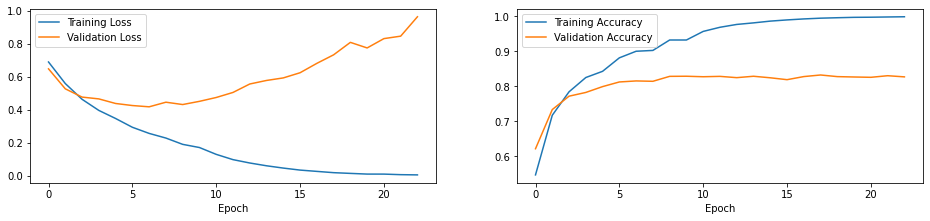


Training model RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(True)_DR(0.5)

Early stopping at epoch 30


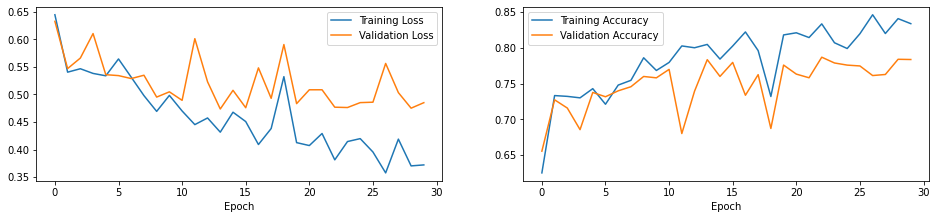


Training model RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)

Early stopping at epoch 20


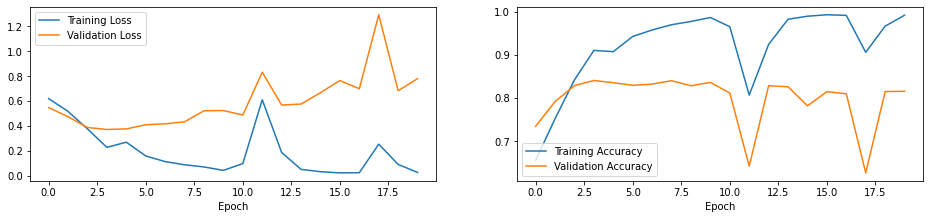

In [ ]:
trained_rnn_models = train_models(rnn_models)

In [ ]:
rnn_val_metrics_df = get_metrics_from_saved_models(rnn_models,val_X_tensor,val_y_tensor,"Val")
rnn_val_metrics_df

Best Model (By Loss) Model ID                                                   RNN2
Model         RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...
Loss                                                   0.373023
Acc                                                    0.840732
F1                                                     0.821962
MatCorCoef                                              0.68345
Name: 2, dtype: object


,Model ID,Model,Loss,Acc,F1,MatCorCoef
0,RNN0,RNN_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_F...,0.416805,0.815865,0.810008,0.631891
1,RNN1,RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...,0.473074,0.783395,0.770969,0.565563
2,RNN2,RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...,0.373023,0.840732,0.821962,0.683450


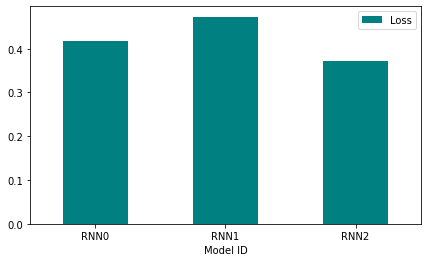

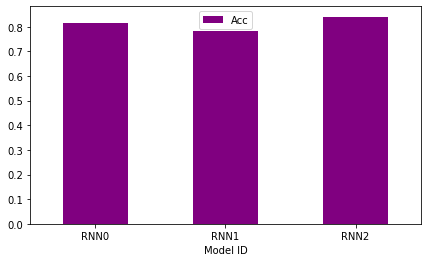

In [ ]:
rnn_val_df = plot_models(rnn_val_metrics_df)

RNN_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
Test
Loss Function:  0.4130581404050641
Accuracy Score:  0.8259958071278826
F1 Score:  0.8216758176175699
Matthews Corr Coeff:  0.6527029973439757
Confusion Matrix: 
 [[1825  424]
 [ 323 1721]]


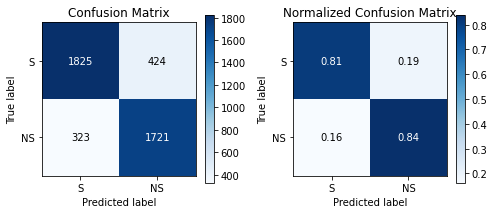



RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(True)_DR(0.5)
Test
Loss Function:  0.47576791888735054
Accuracy Score:  0.7836012112741673
F1 Score:  0.7714637146371462
Matthews Corr Coeff:  0.5660233721566508
Confusion Matrix: 
 [[1796  453]
 [ 476 1568]]


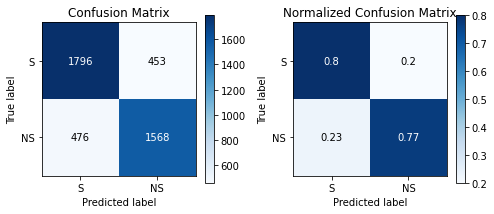



RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
Test
Loss Function:  0.35528664112884195
Accuracy Score:  0.8537153505706965
F1 Score:  0.8372213582166925
Matthews Corr Coeff:  0.7093959027536748
Confusion Matrix: 
 [[2050  199]
 [ 429 1615]]


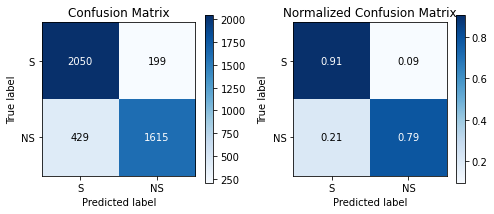

In [ ]:
evaluate_best_models_test_set(rnn_models)

In [ ]:
rnn_test_metrics_df = get_metrics_from_saved_models(rnn_models,test_X_tensor,test_y_tensor,"Test")
rnn_test_metrics_df


Best Model (By Loss) Model ID                                                   RNN2
Model         RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...
Loss                                                   0.373023
Acc                                                    0.840732
F1                                                     0.821962
MatCorCoef                                              0.68345
Name: 2, dtype: object


,Model ID,Model,Loss,Acc,F1,MatCorCoef
0,RNN0,RNN_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_F...,0.416805,0.815865,0.810008,0.631891
1,RNN1,RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...,0.473074,0.783395,0.770969,0.565563
2,RNN2,RNN_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...,0.373023,0.840732,0.821962,0.683450


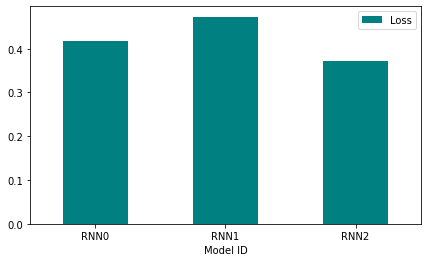

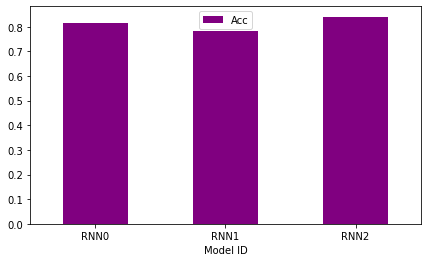

In [ ]:
rnn_test_df = plot_models(rnn_test_metrics_df)

#**LSTM**

In [ ]:
lstm_models = []
for num_layers in num_layers_list:
  for hidden_dim in hidden_dim_list:
    for linear_layers in linear_layers_list:
      for bidirectional in bidirectional_list:
        #No pretrained word embeddings
        lstm_models.append(LSTM(input_dim, embedding_dim,embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = False, freeze = False, drate = drate))
        #Initialise with pretrained word embeddings but don't update further
        lstm_models.append(LSTM(input_dim, embedding_dim,embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = True, freeze = True, drate = drate))
        #Initialise with pretrained word embeddings and update
        lstm_models.append(LSTM(input_dim, embedding_dim,embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = True, freeze = False, drate = drate))

for model in lstm_models:
  print(model.model_name())

print(len(lstm_models))

LSTM_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(True)_DR(0.5)
LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
3


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



Training model LSTM_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)

Early stopping at epoch 21


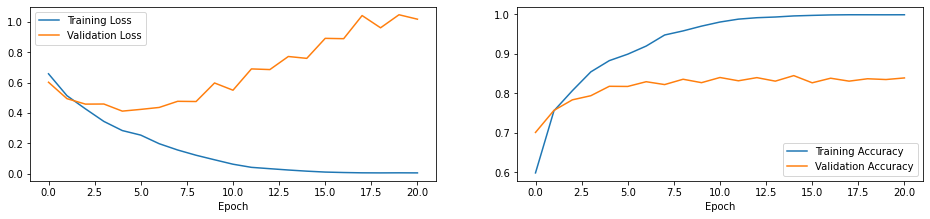


Training model LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(True)_DR(0.5)

Early stopping at epoch 42


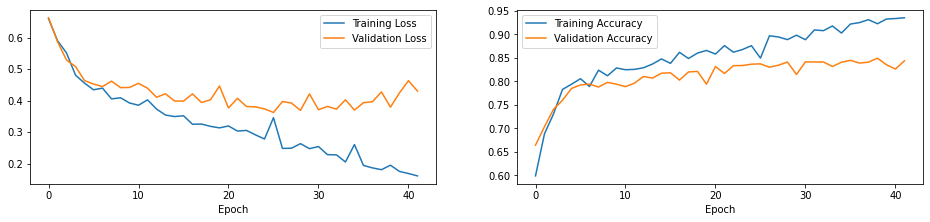


Training model LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)

Early stopping at epoch 21


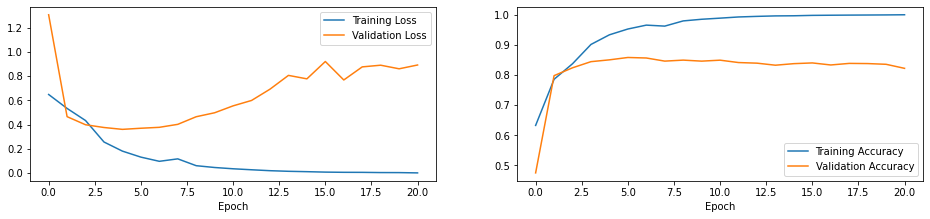

In [ ]:
trained_lstm_models = train_models(lstm_models)

In [ ]:
lstm_val_metrics_df = get_metrics_from_saved_models(lstm_models,val_X_tensor,val_y_tensor,"Val")
lstm_val_metrics_df

Best Model (By Loss) Model ID                                                  LSTM2
Model         LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_F...
Loss                                                   0.361052
Acc                                                    0.849774
F1                                                     0.836429
MatCorCoef                                             0.699418
Name: 2, dtype: object


,Model ID,Model,Loss,Acc,F1,MatCorCoef
0,LSTM0,LSTM_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_...,0.413502,0.817509,0.810175,0.634632
1,LSTM1,LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_F...,0.362970,0.837032,0.820872,0.674348
2,LSTM2,LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_F...,0.361052,0.849774,0.836429,0.699418


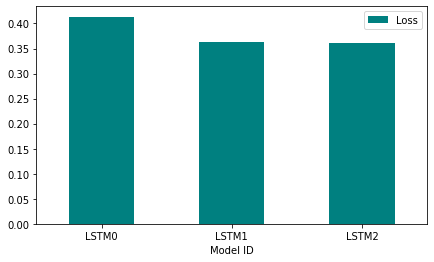

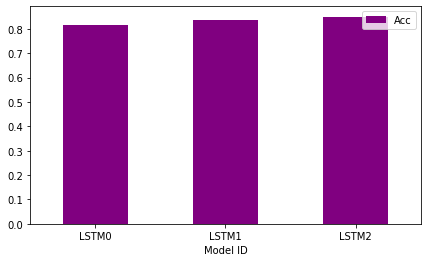

In [ ]:
lstm_val_df = plot_models(lstm_val_metrics_df)

LSTM_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
Test
Loss Function:  0.3861941655307241
Accuracy Score:  0.8297228045655719
F1 Score:  0.8225297402282107
Matthews Corr Coeff:  0.6589719965926366
Confusion Matrix: 
 [[1868  381]
 [ 350 1694]]


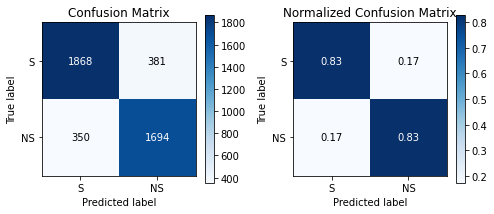



LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(True)_DR(0.5)
Test
Loss Function:  0.3474119839375619
Accuracy Score:  0.8369438621010948
F1 Score:  0.8204207285787583
Matthews Corr Coeff:  0.6744339693238541
Confusion Matrix: 
 [[1994  255]
 [ 445 1599]]


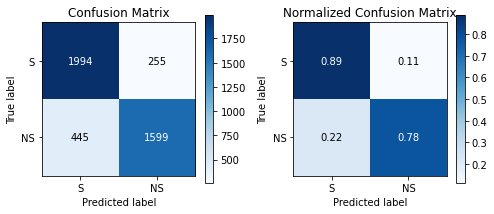



LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
Test
Loss Function:  0.3505806734641932
Accuracy Score:  0.8621010948054973
F1 Score:  0.8494404883011191
Matthews Corr Coeff:  0.7245452457486754
Confusion Matrix: 
 [[2031  218]
 [ 374 1670]]


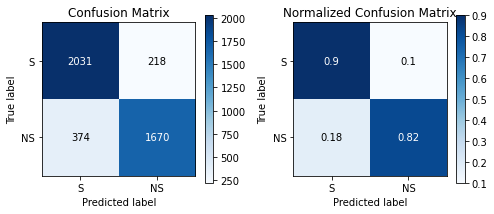

In [ ]:
evaluate_best_models_test_set(lstm_models)

In [ ]:
lstm_test_metrics_df = get_metrics_from_saved_models(lstm_models,test_X_tensor,test_y_tensor,"Test")
lstm_test_metrics_df

Best Model (By Loss) Model ID                                                  LSTM2
Model         LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_F...
Loss                                                   0.361052
Acc                                                    0.849774
F1                                                     0.836429
MatCorCoef                                             0.699418
Name: 2, dtype: object


,Model ID,Model,Loss,Acc,F1,MatCorCoef
0,LSTM0,LSTM_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_...,0.413502,0.817509,0.810175,0.634632
1,LSTM1,LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_F...,0.362970,0.837032,0.820872,0.674348
2,LSTM2,LSTM_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_F...,0.361052,0.849774,0.836429,0.699418


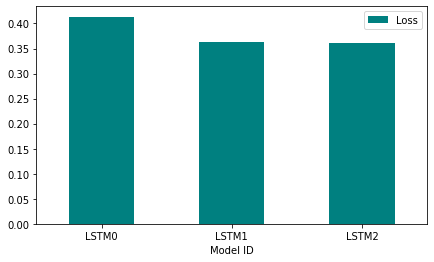

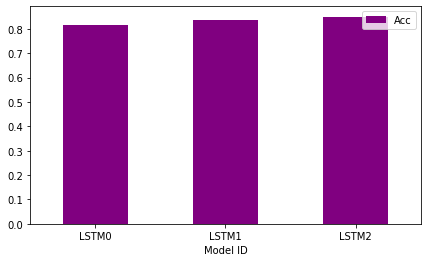

In [ ]:
lstm_test_df = plot_models(lstm_test_metrics_df)

#**GRU**

In [ ]:
gru_models = []
for num_layers in num_layers_list:
  for hidden_dim in hidden_dim_list:
    for linear_layers in linear_layers_list:
      for bidirectional in bidirectional_list:
        gru_models.append(GRU(input_dim, embedding_dim,embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = False, freeze = False, drate = drate))
        gru_models.append(GRU(input_dim, embedding_dim,embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = True, freeze = True, drate = drate))
        gru_models.append(GRU(input_dim, embedding_dim,embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, linear_layers, pretrained = True, freeze = False, drate = drate))

for model in gru_models:
  print(model.model_name())

print(len(gru_models))

GRU_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(True)_DR(0.5)
GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
3


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



Training model GRU_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)

Early stopping at epoch 22


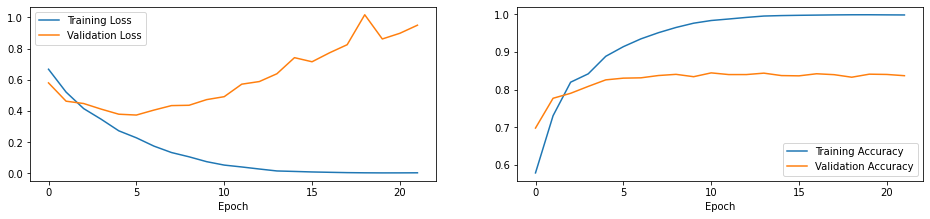


Training model GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(True)_DR(0.5)

Early stopping at epoch 52


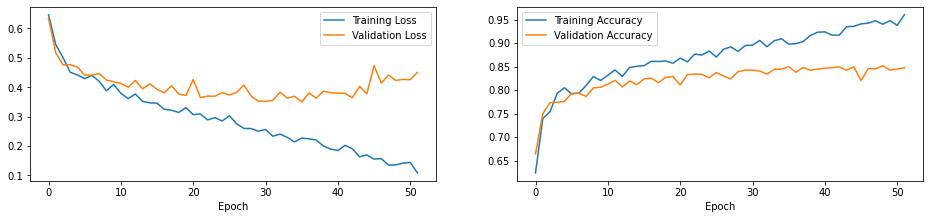


Training model GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)

Early stopping at epoch 19


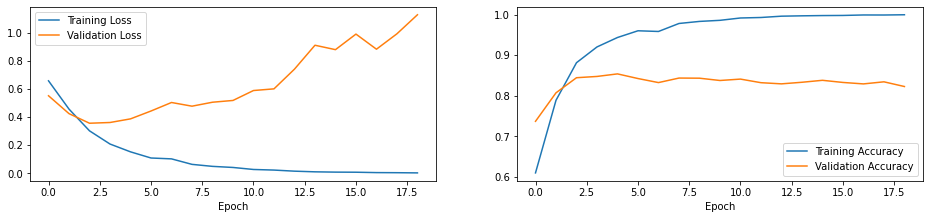

In [ ]:
trained_gru_models = train_models(gru_models)

In [ ]:
gru_val_metrics_df = get_metrics_from_saved_models(gru_models,val_X_tensor,val_y_tensor,"Val")
gru_val_metrics_df


Best Model (By Loss) Model ID                                                   GRU1
Model         GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...
Loss                                                   0.351705
Acc                                                    0.848952
F1                                                     0.841697
MatCorCoef                                              0.69728
Name: 1, dtype: object


,Model ID,Model,Loss,Acc,F1,MatCorCoef
0,GRU0,GRU_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_F...,0.374905,0.830456,0.824431,0.660847
1,GRU1,GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...,0.351705,0.848952,0.841697,0.697280
2,GRU2,GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...,0.355708,0.844636,0.839898,0.689605


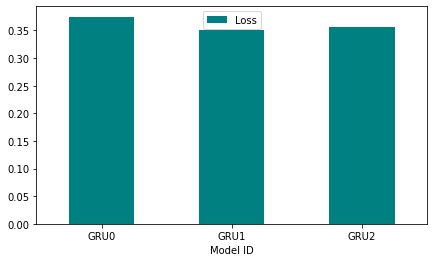

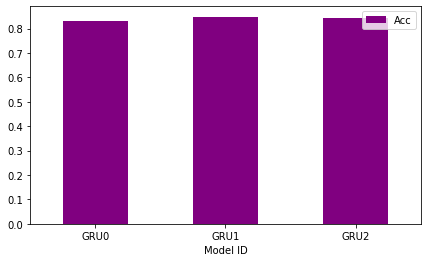

In [ ]:
gru_val_df = plot_models(gru_val_metrics_df)

GRU_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
Test
Loss Function:  0.35783815871675195
Accuracy Score:  0.8443978569764733
F1 Score:  0.8380213385063044
Matthews Corr Coeff:  0.6884317541997337
Confusion Matrix: 
 [[1897  352]
 [ 316 1728]]


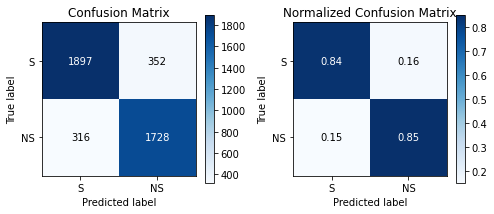



GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(True)_DR(0.5)
Test
Loss Function:  0.33602437030421883
Accuracy Score:  0.853482413230841
F1 Score:  0.8467722289890378
Matthews Corr Coeff:  0.7064286286824044
Confusion Matrix: 
 [[1926  323]
 [ 306 1738]]


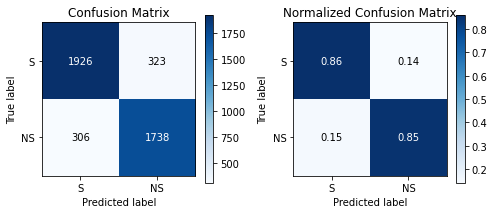



GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR(False)_DR(0.5)
Test
Loss Function:  0.3508156903922145
Accuracy Score:  0.8506871651525739
F1 Score:  0.846024501561374
Matthews Corr Coeff:  0.7016204662273479
Confusion Matrix: 
 [[1891  358]
 [ 283 1761]]


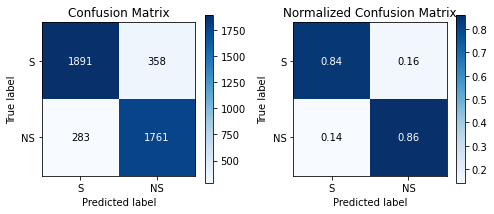

In [ ]:
evaluate_best_models_test_set(gru_models)

In [ ]:
gru_test_metrics_df = get_metrics_from_saved_models(gru_models,test_X_tensor,test_y_tensor,"Test")
gru_test_metrics_df

Best Model (By Loss) Model ID                                                   GRU1
Model         GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...
Loss                                                   0.351705
Acc                                                    0.848952
F1                                                     0.841697
MatCorCoef                                              0.69728
Name: 1, dtype: object


,Model ID,Model,Loss,Acc,F1,MatCorCoef
0,GRU0,GRU_PRE(False)_HD(128)_NL(1)_B(False)_LL([])_F...,0.374905,0.830456,0.824431,0.660847
1,GRU1,GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...,0.351705,0.848952,0.841697,0.697280
2,GRU2,GRU_PRE(True)_HD(128)_NL(1)_B(False)_LL([])_FR...,0.355708,0.844636,0.839898,0.689605


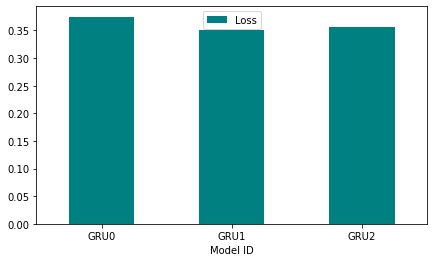

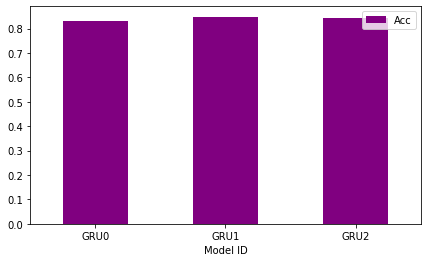

In [ ]:
gru_test_df = plot_models(gru_test_metrics_df)

# **CNN**

In [ ]:
learningrates = [1e-3]#[1e-3, 3e-4]
dropouts = [0.5]#[0.2,0.5]
freeze_embeddings = [False]#[True,False]
linear_layers = [[64,32,16]]#[[64,32,16],
                          #  [64,32],
                          #  [512,128,64,32],
                          #  [512,128,64]]

cnn_models = []
for lr in learningrates:
  for drate in dropouts:
    for freeze in freeze_embeddings:
      for linear_layer in linear_layers:
        cnn_models.append(CNN1d(input_dim, embedding_dim, embedding_matrix, 
                            300, [1,2,3,4,5,10,20], output_dim, linear_layer, 
                            pretrained=True,freeze=freeze, lr=lr, drate=drate))

for model in cnn_models:
  print(model.model_name())

print(len(cnn_models))

CNN1d_PRE(True)_LR(0.001)_NFILTERS(300)_LINEARLAYERS([64, 32, 16])_FILTERSIZES([1, 2, 3, 4, 5, 10, 20])_FR(False)_DR(0.5)
1



Training model CNN1d_PRE(True)_LR(0.001)_NFILTERS(300)_LINEARLAYERS([64, 32, 16])_FILTERSIZES([1, 2, 3, 4, 5, 10, 20])_FR(False)_DR(0.5)

Early stopping at epoch 20


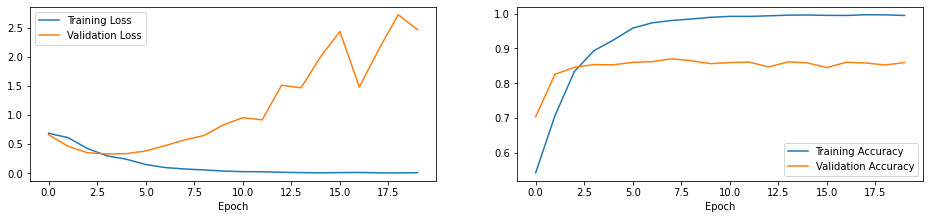

In [ ]:
trained_cnn_models = train_models(cnn_models)

In [ ]:
cnn_val_metrics_df = get_metrics_from_saved_models(cnn_models,val_X_tensor,val_y_tensor,"Val")
cnn_val_metrics_df

Best Model (By Loss) Model ID                                                 CNN1d0
Model         CNN1d_PRE(True)_LR(0.001)_NFILTERS(300)_LINEAR...
Loss                                                   0.333189
Acc                                                    0.853268
F1                                                     0.832709
MatCorCoef                                             0.711777
Name: 0, dtype: object


,Model ID,Model,Loss,Acc,F1,MatCorCoef
0,CNN1d0,CNN1d_PRE(True)_LR(0.001)_NFILTERS(300)_LINEAR...,0.333189,0.853268,0.832709,0.711777


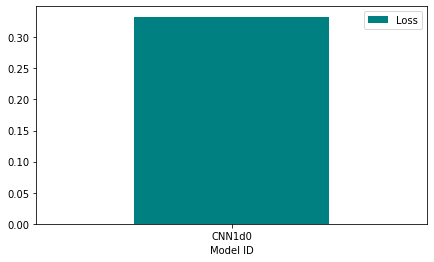

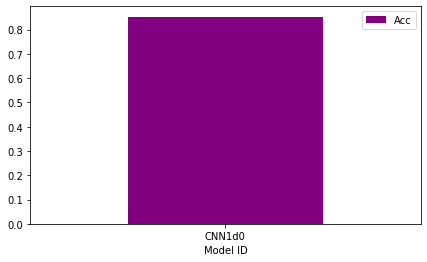

In [ ]:
cnn_val_df = plot_models(cnn_val_metrics_df)

CNN1d_PRE(True)_LR(0.001)_NFILTERS(300)_LINEARLAYERS([64, 32, 16])_FILTERSIZES([1, 2, 3, 4, 5, 10, 20])_FR(False)_DR(0.5)
Test
Loss Function:  0.3177006995197953
Accuracy Score:  0.8618681574656417
F1 Score:  0.843741765480896
Matthews Corr Coeff:  0.7282224032152277
Confusion Matrix: 
 [[2099  150]
 [ 443 1601]]


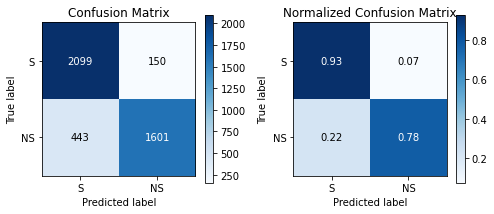

In [ ]:
evaluate_best_models_test_set(cnn_models)

In [ ]:
cnn_test_metrics_df = get_metrics_from_saved_models(cnn_models,test_X_tensor,test_y_tensor,"Test")
cnn_test_metrics_df

Best Model (By Loss) Model ID                                                 CNN1d0
Model         CNN1d_PRE(True)_LR(0.001)_NFILTERS(300)_LINEAR...
Loss                                                   0.333189
Acc                                                    0.853268
F1                                                     0.832709
MatCorCoef                                             0.711777
Name: 0, dtype: object


,Model ID,Model,Loss,Acc,F1,MatCorCoef
0,CNN1d0,CNN1d_PRE(True)_LR(0.001)_NFILTERS(300)_LINEAR...,0.333189,0.853268,0.832709,0.711777


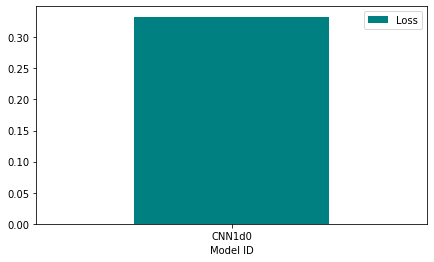

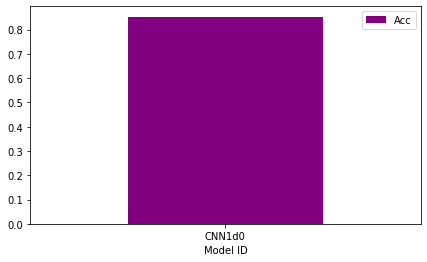

In [ ]:
cnn_test_df = plot_models(cnn_test_metrics_df)